In [1]:
import pandas as pd
import numpy as np
import os
np.random.seed(42)
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(os.path.abspath(".."))  

from FinalToolModels.models import *
from FinalToolModels.simulate import *
from FinalToolModels.plot import *
from FinalToolModels.train import *
from FinalToolModels.split_dataset import *

# === Paths ===
path_in = os.path.join("../Data")  # parent directory

###################### ======================== Case Study 1 ======================= ###########################

file_path = os.path.join(path_in, "dataset2.xlsx")
cs1 = pd.read_excel(file_path)

cs1["INDOOR_TEMP"] = cs1[["RTD31", "RTD34", "RTD37", "RTD40", "RTD41"]].mean(axis=1)
# Rename columns
rename_mapping = {
        'Tout': 'OUTDOOR_TEMP',
        'PhRad_actual_power': 'PHI_H',
        'SolGlob': 'PYRANOMETER'
    }
cs1 = cs1.rename(columns=rename_mapping)
# Convert 't' to datetime and set as index

cs1['Time'] = pd.to_datetime(cs1['Time'])
cs1 = cs1.set_index('Time')
cs1_surface_area = 100  # m² 
cs1 = cs1.iloc[0:960]

train_cs1, val_cs1, test_cs1 = split_dataset(cs1, testing_days=3, val_split=1.0)


In [2]:
#### Function

def run_case_study(train_df,val_df, surface_area, model_type, label, bounds, trials):
    
    model, parameters, initialization, all_trials = train_greybox_model(
        train_df=train_df,
        model_type=model_type,
        bounds=bounds,
        solver_name="ipopt",
        num_trials=trials,
        deltaT=1800,
        show_plot=False
    )

    best_obj = all_trials['Objective'].min()
    mean_obj = all_trials["Objective"].mean()
    std_obj = all_trials["Objective"].std()
    matches = (np.round(all_trials['Objective'], 5) == np.round(best_obj, 5))
    n_matches = matches.sum()
    n_total = len(all_trials)
    success_rate = 100 * n_matches / n_total

    print(f"[{label}] Best Objective achieved in {n_matches} out of {n_total} trials.")
    print(f"[{label}] Success rate: {success_rate:.2f}%")
    print(f"[{label}] Best Objective was equal to {best_obj}")
    print(f"[{label}] Mean RMSE: {mean_obj:.2f}")
    print(f"[{label}] RMSE Std. Dev.: {std_obj:.2f}")
    print("\n")

    last_index = max(model.T_in.index_set())
    # --- Validation Initialization (from last training value) ---
    if model_type == "1R1C":
        initialize_validation = {"Tin": model.T_in[last_index]()}
    elif model_type == "2R2C_A":
        initialize_validation = {"Te": model.T_e[last_index](), "Tin": model.T_in[last_index]()}
    elif model_type == "3R2C":
        initialize_validation = {"Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}
    elif model_type == "4R3C":
        initialize_validation = {"Tint": model.T_int[last_index](), "Tin": model.T_in[last_index](), "Te": model.T_e[last_index]()}

    # --- Run Simulation and Validation ---
    validation, t_pred, t_true, val_pred = simulate_and_evaluate(
            val_df=val_df,
            param_dict=parameters,
            model_type=model_type,
            initializations=initialize_validation,
            show_plot=True
        )
    
    print(f"[{label}] Training RMSE: {np.sqrt(model.obj())}")
    print(f"Validation RMSE: {validation['RMSE']:.4f}")
    print("\n")
    return model,  val_pred, all_trials

## 1R1C

[Trial 1] RMSE = 0.6641, Init: {'R_in_a': 0.37516557872851514, 'C_in': 475406438.8985482, 'Ain': 21.96008626040034}
 parameters: {'R_in_a': 0.014324465673329746, 'C_in': 230616064.22648215, 'Ain': 0.001001581693058919, 'fh': 1, 'Objective': 0.4410102307561626, 'Solve_time': 0.035859107971191406}
[Trial 2] RMSE = 0.5459, Init: {'R_in_a': 0.5990598257128396, 'C_in': 78853301.58077583, 'Ain': 4.680679615565744}
 parameters: {'R_in_a': 0.014010186942034005, 'C_in': 87896160.92045338, 'Ain': 1.171266345157453, 'fh': 1, 'Objective': 0.2979802996020128, 'Solve_time': 0.04409074783325195}
[Trial 3] RMSE = 0.6139, Init: {'R_in_a': 0.05902552855603126, 'C_in': 433221896.74169266, 'Ain': 18.03384923728452}
 parameters: {'R_in_a': 0.014315553697003353, 'C_in': 137606875.98718017, 'Ain': 0.19976502306270588, 'fh': 1, 'Objective': 0.37683399315237, 'Solve_time': 0.04246091842651367}
[Trial 4] RMSE = 0.1756, Init: {'R_in_a': 0.7083645052182495, 'C_in': 11271662.65360542, 'Ain': 29.09732565500767}
 pa

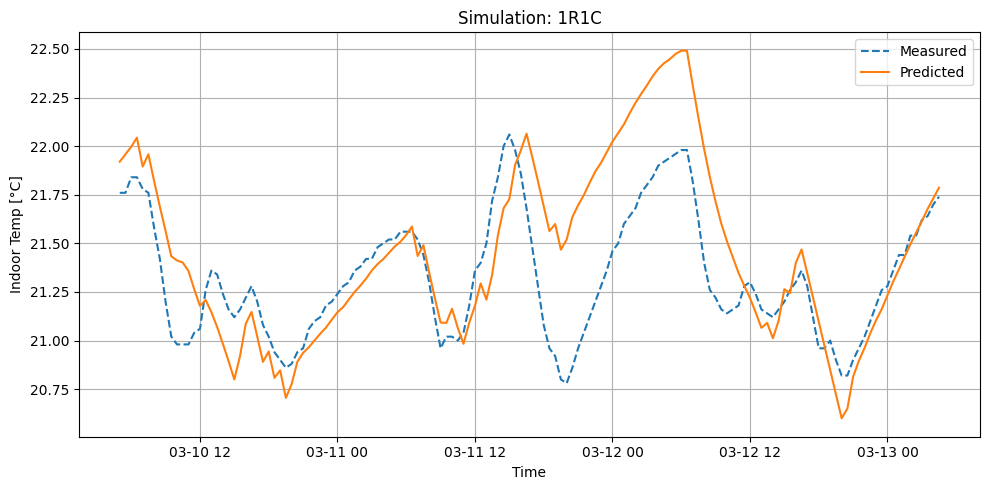

[Case Study 1] Training RMSE: 0.1755643696835501
Validation RMSE: 0.3201




In [3]:
# Bounds 
bounds_cs1 = {
        "R_in_a": (0.001, 1),
        "C_in": (1e6, 5e8),
        "Ain": (0.001, 0.3 * cs1_surface_area)
    }
model_1r1c_cs1, val_pred_1r1c_cs1, all_trials_1r1c_cs1 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, model_type="1R1C", label="Case Study 1", bounds=bounds_cs1, trials=100)


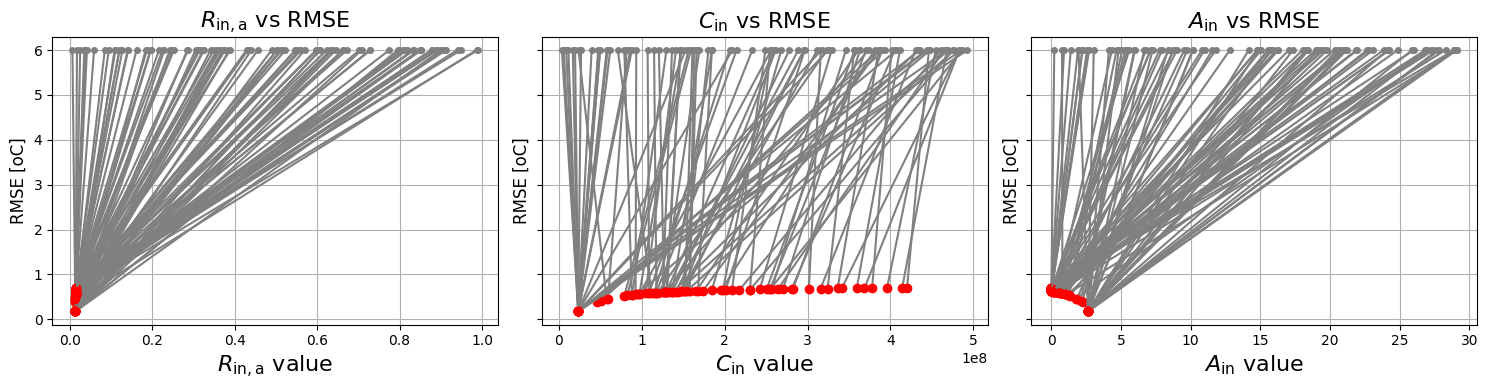

In [4]:
param_list = ['R_in_a', 'C_in', 'Ain']

plot_parameters_vs_rmse_multi(all_trials_1r1c_cs1, param_list, y_start=6, rmse_threshold=6)

# 2R2C

[Trial 1] RMSE = 0.6208, Init: {'R_e_a': 0.05263003944743909, 'R_in_e': 0.5318232769365798, 'C_in': 270776925.6834431, 'C_e': 319077520.84760505, 'Ain': 21.783013920346125, 'Ae': 29.275586531796577, 'fh': 0.5163003483011953}
 parameters: {'R_in_e': 0.0347666963727572, 'R_e_a': 0.006362313085008901, 'C_in': 6521240.071879523, 'C_e': 147657838.08315638, 'Ain': 0.0010000615163438845, 'Ae': 29.999991964655834, 'fh': 0.06740811821588985, 'Objective': 0.3854239266102184, 'Solve_time': 0.6206259727478027}
[Trial 2] RMSE = 0.6736, Init: {'R_e_a': 0.32363351646830474, 'R_in_e': 0.795391008573935, 'C_in': 136145293.37977505, 'C_e': 220046738.93211243, 'Ain': 2.354612983886636, 'Ae': 0.7614969517203098, 'fh': 0.9626484146779251}
 parameters: {'R_in_e': 0.0009999920551994955, 'R_e_a': 0.004255560811952638, 'C_in': 499482290.171627, 'C_e': 431129288.8295295, 'Ain': 23.441295199327076, 'Ae': 29.99999589403261, 'fh': 0.9999994863368752, 'Objective': 0.4537790487830539, 'Solve_time': 0.193382024765014

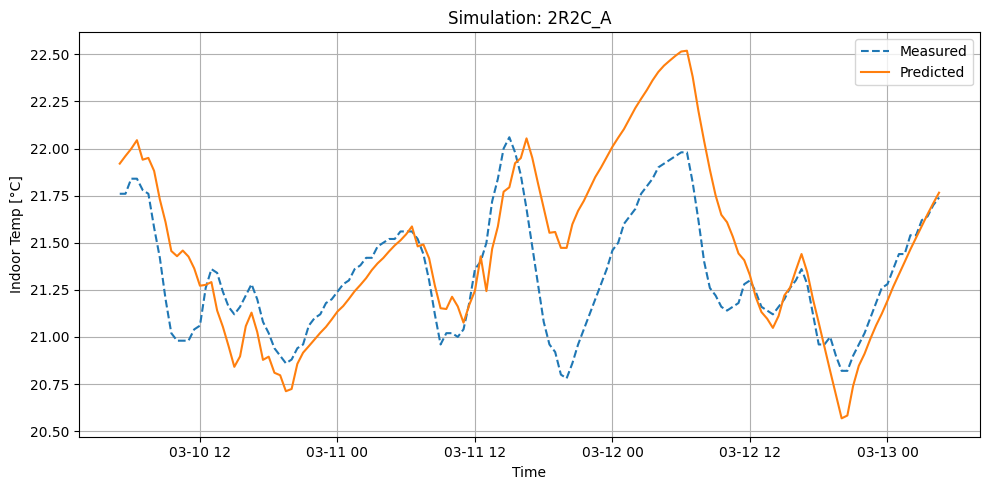

[Case Study 1] Training RMSE: 0.16884407339127236
Validation RMSE: 0.3245




In [5]:
import numpy as np

# --- Bounds ---

bounds_cs1 = {
    "R_e_a": (0.001, 1),
    "R_in_e": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.001, 0.3 * cs1_surface_area),
    "Ae": (0.001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
model_2r2c_cs1, val_pred_2r2c_cs1, all_trials_2r2c_cs2 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="2R2C_A", bounds=bounds_cs1, trials=100)


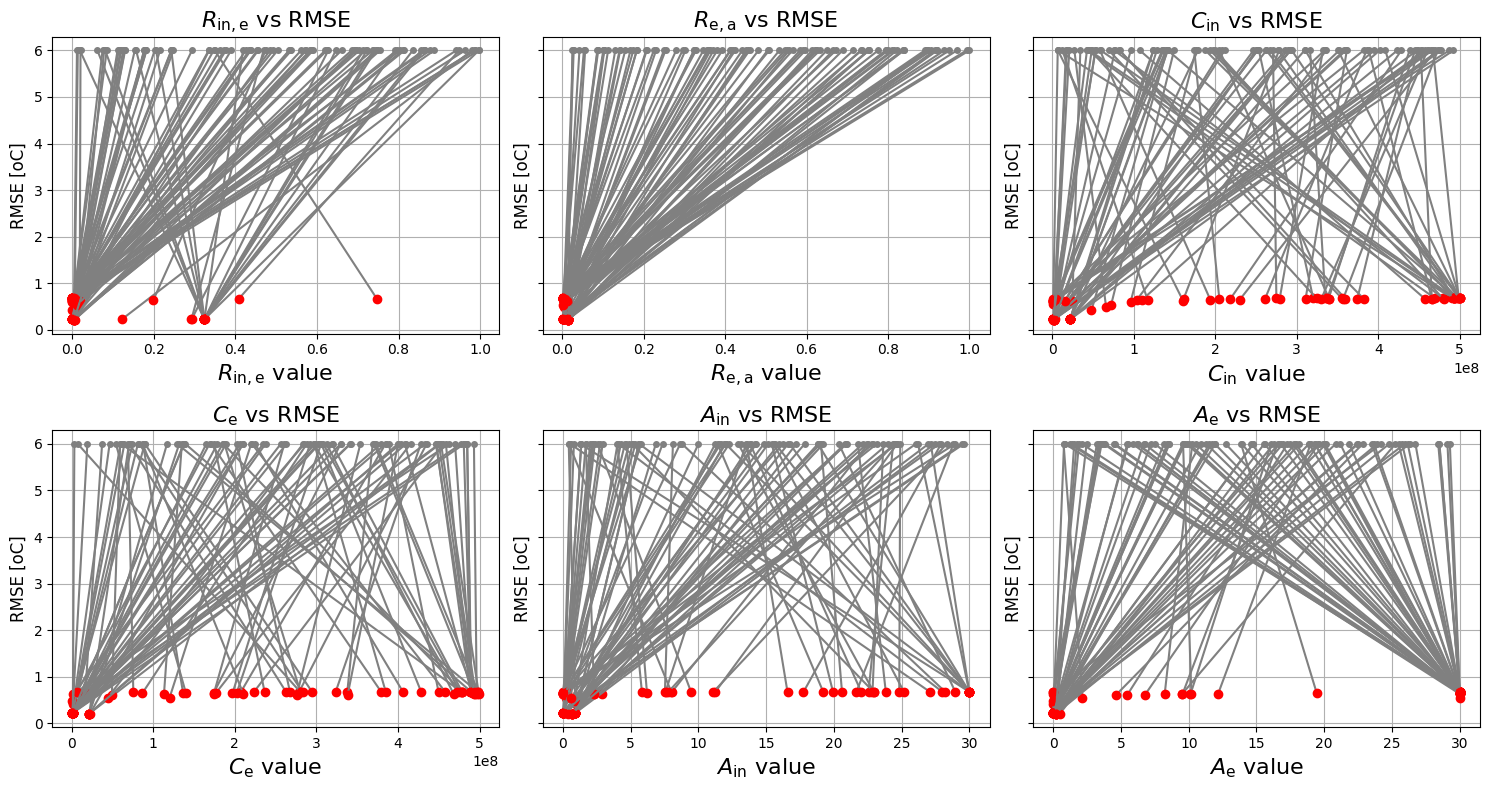

In [ ]:
param_list = ['R_in_e','R_e_a', 'C_in', 'C_e', 'Ain', 'Ae']
plot_parameters_vs_rmse_multi(all_trials_2r2c_cs2, param_list, y_start=6, rmse_threshold=6)

[Trial 1] RMSE = 0.5888, Init: {'R_in_e': 0.18594779590978103, 'R_e_a': 0.5423590464309798, 'R_in_a': 0.8730728900405319, 'C_in': 366380218.31837106, 'C_e': 403474012.78286344, 'Ain': 19.763535122984848, 'Ae': 20.768327707879124, 'fh': 0.8491956515653193}
 parameters: {'R_in_e': 0.002008305636020551, 'R_e_a': 0.9999927743177305, 'R_in_a': 0.00497570932808841, 'C_in': 385839696.1514944, 'C_e': 411194564.2667805, 'Ain': 29.99999753761249, 'Ae': 29.99999733522372, 'fh': 0.9999998974175351, 'Objective': 0.34672481533118876, 'Solve_time': 0.5138909816741943}
[Trial 2] RMSE = 0.6334, Init: {'R_in_e': 0.2504183408503267, 'R_e_a': 0.48993553867949735, 'R_in_a': 0.22198823237778262, 'C_in': 493846335.9903269, 'C_e': 472085610.50362, 'Ain': 1.18290039837404, 'Ae': 21.167284617953403, 'fh': 0.9252483174156658}
 parameters: {'R_in_e': 0.023203716171528724, 'R_e_a': 0.001237628821540376, 'R_in_a': 0.00885010461665229, 'C_in': 458479562.69267064, 'C_e': 397502017.84036374, 'Ain': 29.99999823578765, 

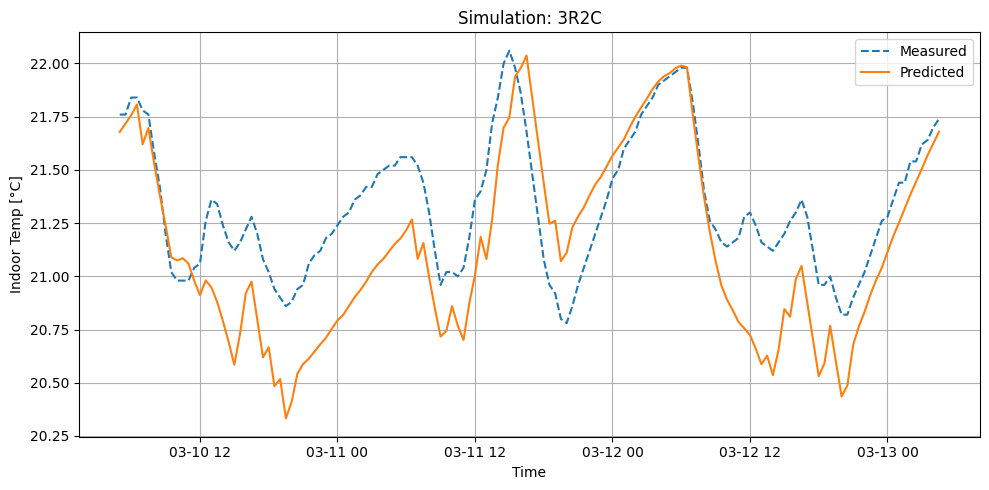

[Case Study 1] Training RMSE: 0.1600213490720383
Validation RMSE: 0.3157




In [18]:
# --- Bounds ---

bounds_cs1 = {
    "R_in_e": (0.001, 1),
    "R_e_a": (0.001, 1),
    "R_in_a": (0.001, 1),
    "C_in": (1e6, 5e8),
    "C_e": (1e6, 5e8),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh": (0,1)
}
model_3r2c_cs1, val_pred_3r2c_cs1, all_trials_3r2c_cs2 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="3R2C", bounds=bounds_cs1, trials=100)


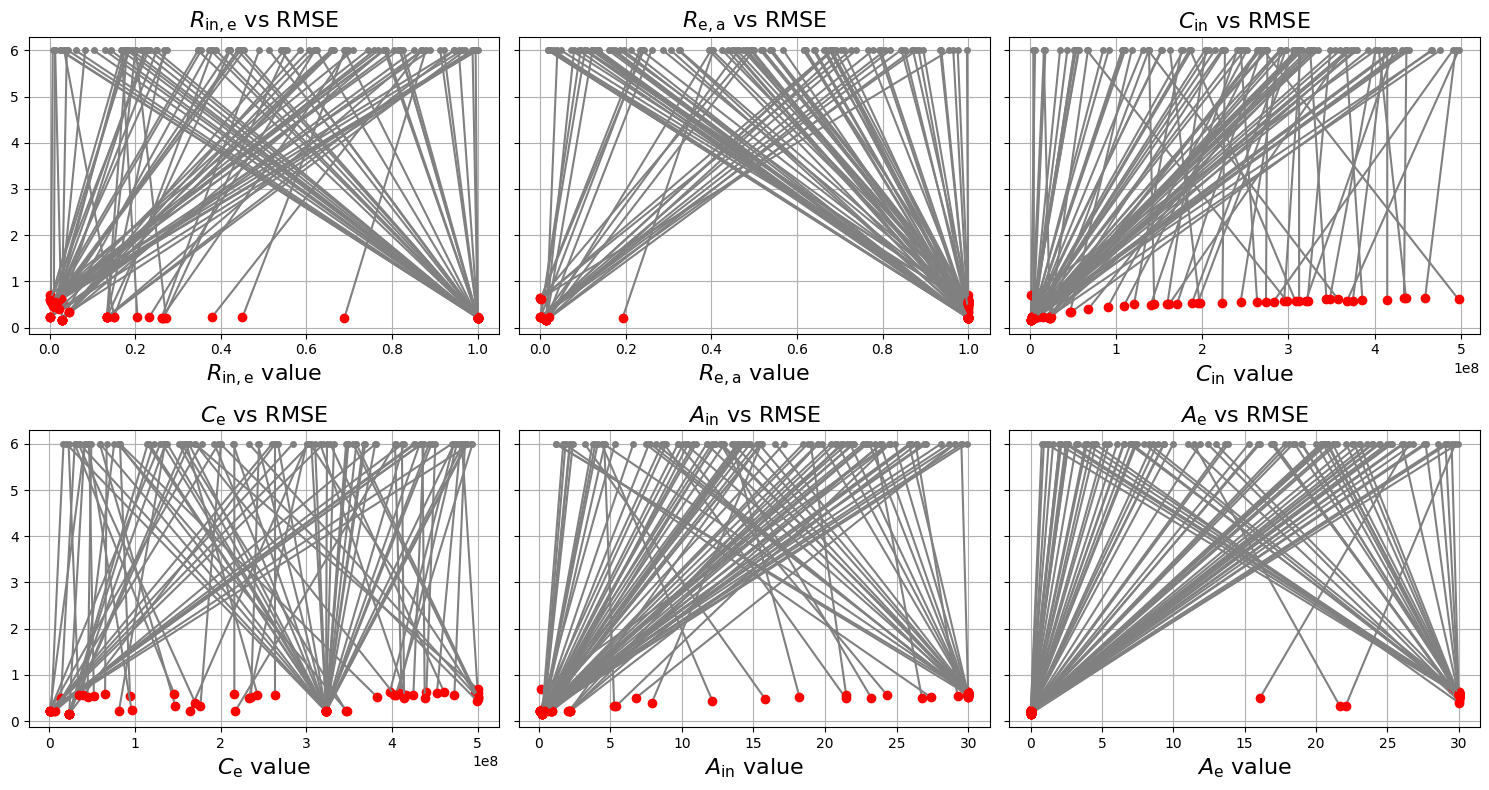

In [19]:
param_list = ['R_in_e','R_e_a', 'C_in', 'C_e', 'Ain', 'Ae']

plot_parameters_vs_rmse_multi(all_trials_3r2c_cs2, param_list, y_start=6, rmse_threshold=6)

[Trial 1] RMSE = 0.5655, Init: {'R_int_in': 0.9565883955028811, 'R_in_e': 0.7380333427400889, 'R_e_a': 0.35454490568506003, 'R_in_a': 0.29794251012507994, 'C_int': 175631970.99722975, 'C_in': 387597181.3531735, 'C_e': 331091660.8019227, 'Aint': 5.555948516467251, 'Ain': 5.223362649088997, 'Ae': 2.9519596518369484, 'fh_int': 0.6603027197013381, 'fh_in': 0.7643726622217359, 'fh_e': 0.265046428325004}
 parameters: {'R_int_in': 0.001999992585938461, 'R_in_e': 0.00199999278764613, 'R_e_a': 0.9999892363290169, 'R_in_a': 0.0035587332527446847, 'C_int': 175632014.0970864, 'C_in': 387597193.6559871, 'C_e': 331091671.0234286, 'Aint': 29.999997461284455, 'Ain': 29.999996028744178, 'Ae': 29.999996444283173, 'fh_int': 1.6086003778067903e-07, 'fh_in': 0.9999997012592977, 'fh_e': 1.3788066462702187e-07, 'Objective': 0.31978256136923244, 'Solve_time': 1.3901171684265137}
[Trial 2] RMSE = 0.1777, Init: {'R_int_in': 0.022903071108850988, 'R_in_e': 0.0840073241414745, 'R_e_a': 0.9679243147753404, 'R_in_a

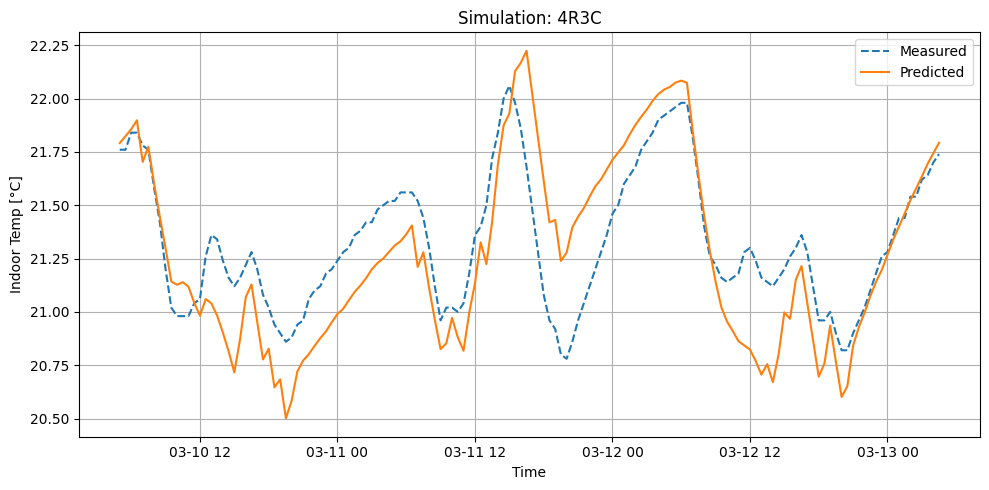

[Case Study 1] Training RMSE: 0.12154874495922181
Validation RMSE: 0.2522




In [20]:
import numpy as np

# --- Bounds ---

bounds_cs1 = {
    "R_int_in": (0.002, 1),
    "R_in_e": (0.002, 1),
    "R_e_a": (0.002, 1),
    "R_in_a": (0.002, 1),
    "C_int": (1.2e6, 5e8),
    "C_in": (1.2e6, 5e8),
    "C_e": (1.2e6, 5e8),
    "Aint": (0.0001, 0.3 * cs1_surface_area),
    "Ain": (0.0001, 0.3 * cs1_surface_area),
    "Ae": (0.0001, 0.3 * cs1_surface_area),
    "fh_int": (0,1),
    "fh_in": (0,1),
    "fh_e": (0,1)
}

model_4r3c_cs1, val_pred_4r3c_cs1, all_trials_4r3c_cs2 = run_case_study(train_df=val_cs1, val_df=test_cs1, surface_area=cs1_surface_area, label="Case Study 1",model_type="4R3C", bounds=bounds_cs1, trials=100)


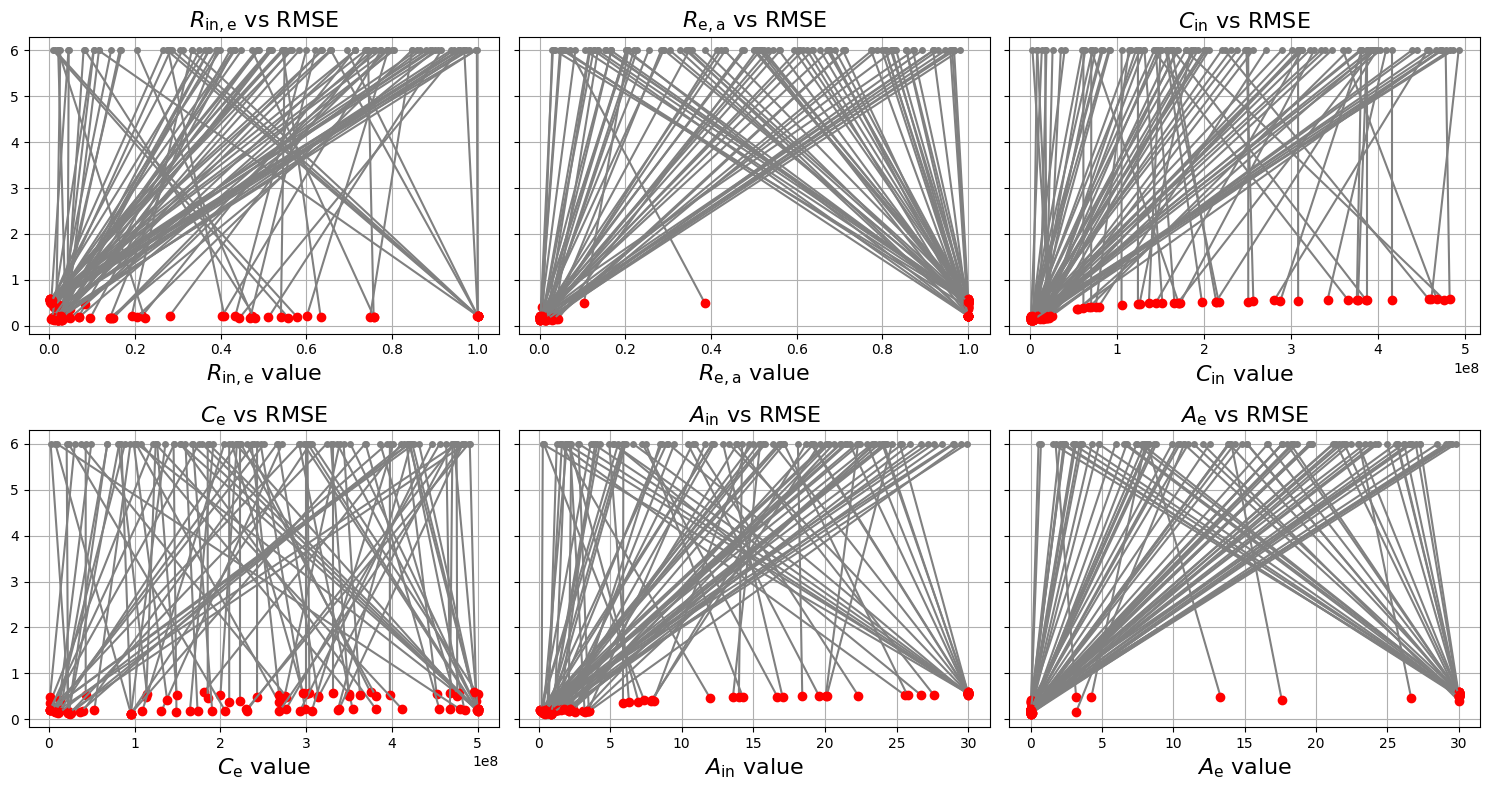

In [21]:
param_list = ['R_in_e','R_e_a', 'C_in', 'C_e', 'Ain', 'Ae']

plot_parameters_vs_rmse_multi(all_trials_4r3c_cs2, param_list, y_start=6, rmse_threshold=6)